In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import logging
import random
import sklearn
from sklearn.manifold import TSNE

tf.get_logger().setLevel(logging.ERROR)

In [2]:
import random
random.seed(42) # Set the random number generator to a fixed sequence.

# Descarga de datos

Vamos a crear un dataframe de fotos de dígitos a la que hemos añadido unas pocas fotos de prendas de ropa. Estas pocas muestras de ropa serán las que consideremos outliers.

El dataframe estará dividido en dos partes: uno de train con poquitas muestras y otra de test con muchas más. Esto unicamente lo hacemos para poder calcular métricas más precisas.

In [3]:
DR_RATE = .2

SAMPLES_TRAIN = 1_000 # Number of train images of digits

N_SAMPLES_OUTLIERS_TRAIN = 50 # Number of train images for clothes
N_SAMPLES_OUTLIERS_TEST = 70

## Digitos

In [4]:
# Load traditional MNIST dataset.
mnist = keras.datasets.mnist

(train_images, _), (test_images, test_labels) = mnist.load_data()
train_images = train_images[np.random.choice(range(len(train_images)), SAMPLES_TRAIN)]

# Scale the data.
train_images = train_images / 255.0
test_images = test_images / 255.0


## Moda

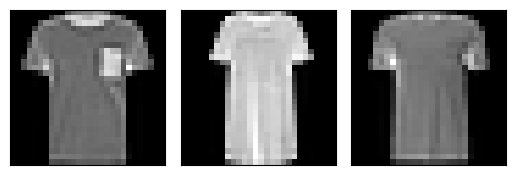

In [5]:
# Load Fashion MNIST.
f_mnist = keras.datasets.fashion_mnist
(f_train_images, f_train_labels), (f_test_images, f_test_labels) = f_mnist.load_data()
# * Normalise it
f_train_images = f_train_images / 255.0
f_test_images = f_test_images / 255.0
# * Choose from the clothes dataset a random subset
f_outliers_train = f_train_images[np.random.choice(range(len(f_train_images)), N_SAMPLES_OUTLIERS_TRAIN)]
f_outliers_test = f_test_images[np.random.choice(range(len(f_test_images)), N_SAMPLES_OUTLIERS_TEST)]

fig, axs = plt.subplots(1, 3,
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(f_outliers_train[i], cmap=plt.get_cmap('gray'))

## Unión de fuentes

In [6]:
corrupted_samples_train = np.append(train_images, f_outliers_train, axis=0)
np.random.shuffle(corrupted_samples_train)

In [7]:
corrupted_samples_test = np.append(test_images, f_outliers_test, axis=0) # * Why don't you subset?

In [8]:
print(f"Length DF train: {len(corrupted_samples_train)}")
print(f"Length DF test: {len(corrupted_samples_test)}")

Length DF train: 1050
Length DF test: 10070


# Autoencoder con Perceptrón multicapa

En primer lugar, vamos a implementar un autoencoder que funciona sobre la versión flat. Por tanto, no se pretende explotar las correlaciones espaciales.

## Entrenamiento

* Kernel Initialiser determines how the weights of the neurons are initially set 
    * This initializer is designed to keep the scale of the gradients roughly the same in all layers to prevent the vanishing or exploding gradients problem in deep networks.
* The bias_initializer='zeros' parameter sets the initial value of the bias terms to zero.


In [9]:
# Create and train autoencoder.
EPOCHS = 80 # ? - Decide on the number of EPOCH's? - We have to apply the early stopping?
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), # ? - Input flatten from the 28 by 28
    # ? - Encoder
    keras.layers.Dense(64, activation='relu',
                       kernel_initializer='glorot_normal',
                       bias_initializer='zeros'),
    keras.layers.Dropout(DR_RATE), # ! - Dropout rate - After each demse layer.
    keras.layers.Dense(32, activation='relu',
                   kernel_initializer='glorot_normal',
                   bias_initializer='zeros'),
    # Decoder
    keras.layers.Dense(64, activation='relu',
                   kernel_initializer='glorot_normal',
                   bias_initializer='zeros'),
    keras.layers.Dropout(DR_RATE),
    keras.layers.Dense(784, activation='sigmoid', # * Output sigmoid
                       kernel_initializer='glorot_normal',
                       bias_initializer='zeros'),
    keras.layers.Dropout(DR_RATE),
    keras.layers.Reshape((28, 28))])

model.compile(loss='binary_crossentropy', optimizer = 'adam',
              metrics =['mean_absolute_error']) # * I still don't really un

history = model.fit(corrupted_samples_train, corrupted_samples_train,
                    validation_split=0.2,
                    epochs=EPOCHS, batch_size=64, verbose=0, 
                    shuffle=True) # * Creation of the auto-encoder

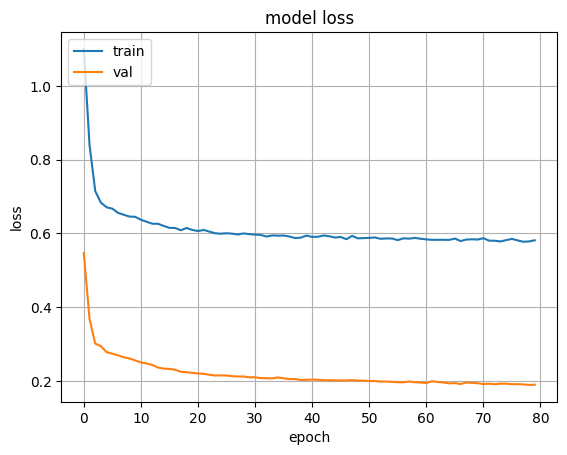

In [10]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid() # * Smaller loss due to a smaller dataset I'm guessing. 

## Visualización de ejemplos

Vamos a comparar como son las imaágenes original y como es la reconstrucción al pasar por el autoencoder.


In [11]:
train_predictions = model.predict(corrupted_samples_train)


33/33 [==============================] - 0s 726us/step


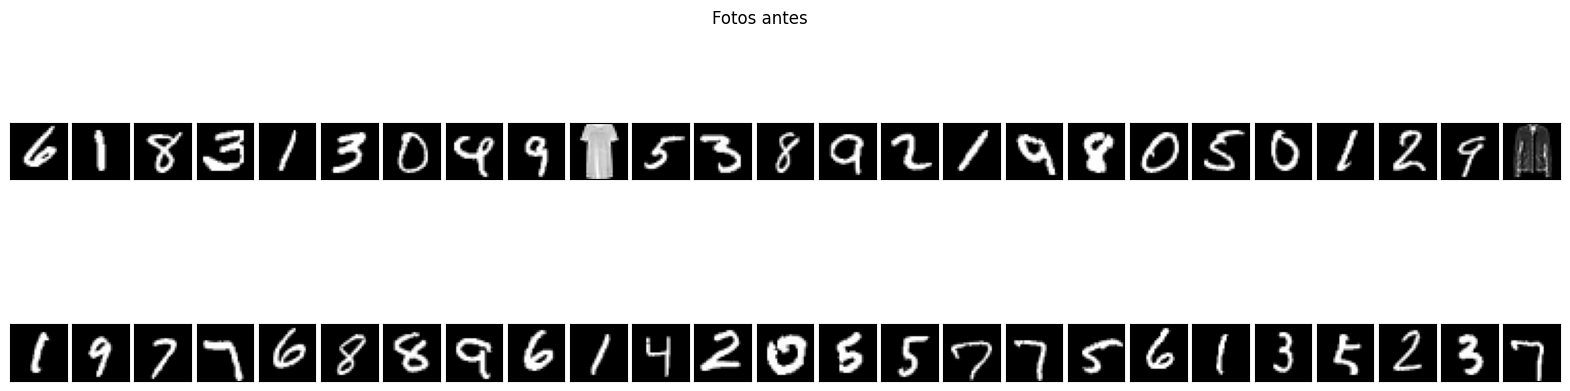

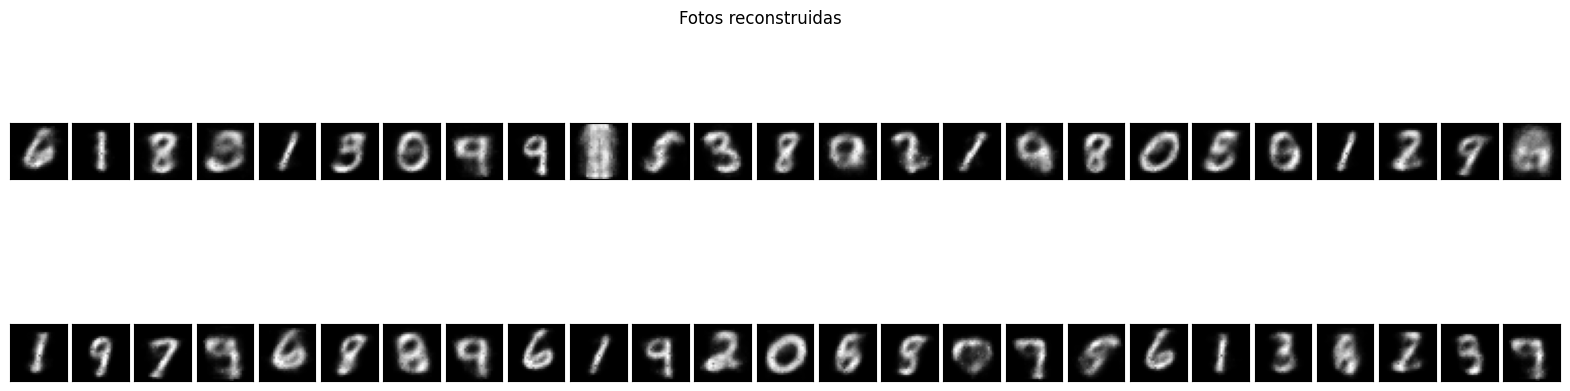

In [12]:
N = 50
fig, axs = plt.subplots(2, N // 2, figsize=(20, 5),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for sample, ax in zip(corrupted_samples_train, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Fotos antes")

fig, axs = plt.subplots(2, N // 2, figsize=(20, 5),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for sample, ax in zip(train_predictions, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Fotos reconstruidas");


## Outliers detectados

Mostramos las imágenes en las que más error se ha cometido en la reconstrucción.

In [13]:
errors = np.mean(np.abs(corrupted_samples_train - train_predictions), (1, 2)) # Computes the mse for each image
indices_ordered_by_error = sorted(enumerate(errors), key=lambda x: x[1], reverse=True) # Gets the indices of the images ordered from higher to lower reconstruction error.

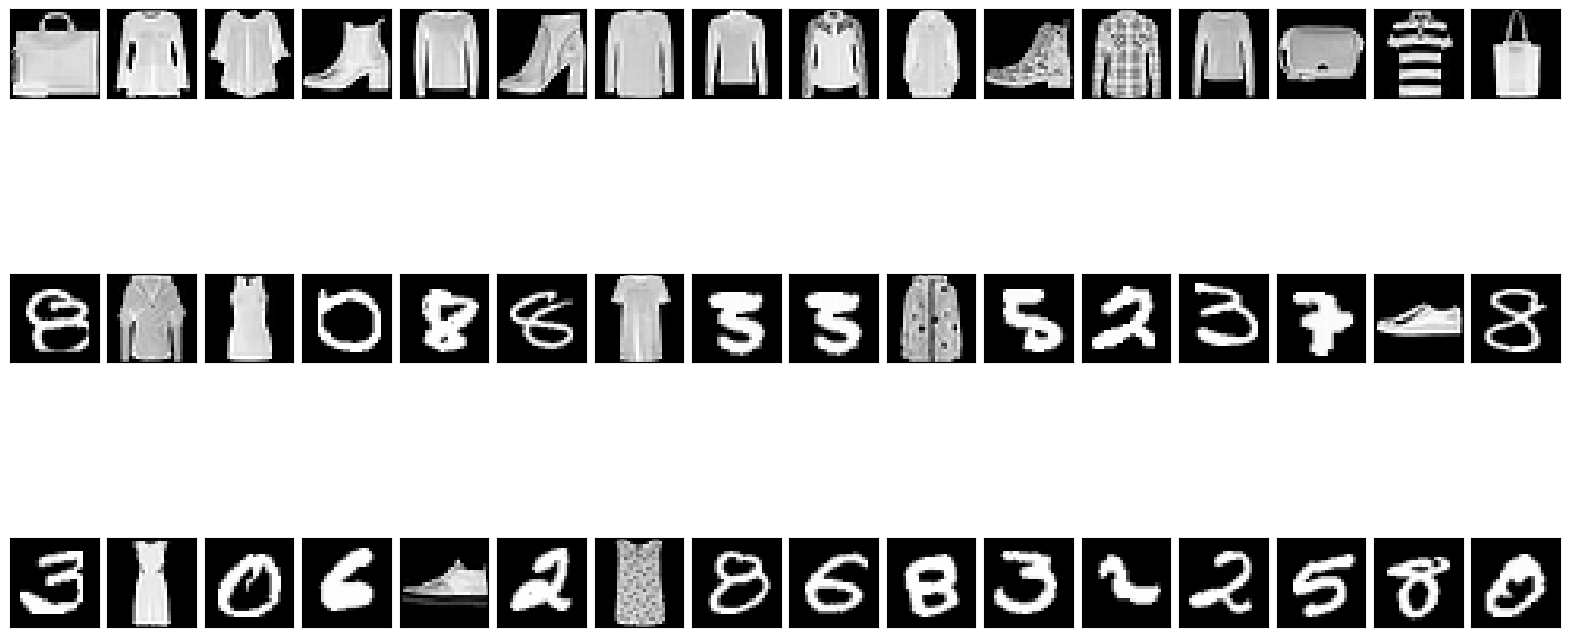

In [14]:
n_outliers = N_SAMPLES_OUTLIERS_TRAIN

fig, axs = plt.subplots(3, n_outliers // 3, figsize=(20, 10),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for (i, e), ax in zip(indices_ordered_by_error[:n_outliers], axs.flatten()):
    ax.imshow(corrupted_samples_train[i], cmap=plt.get_cmap('gray'))

Tomamos algunas muestras no vistas (del dataset de test) y dibujamos como son antes y después de la reconstrucción.

315/315 [==============================] - 0s 735us/step


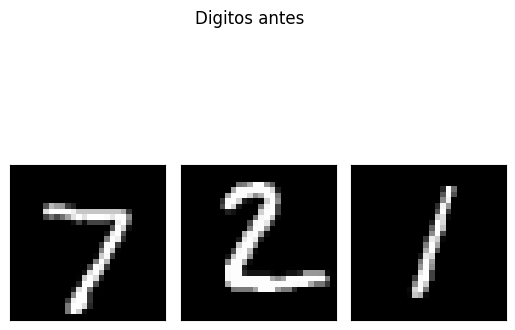

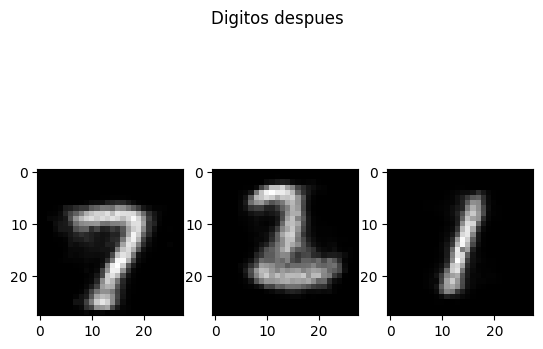

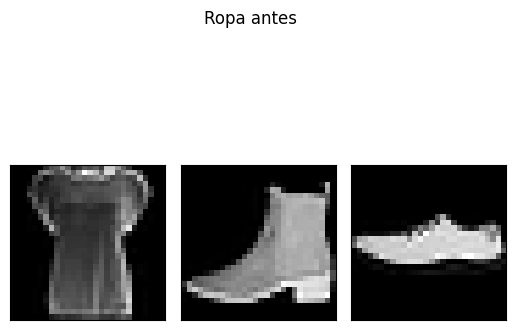

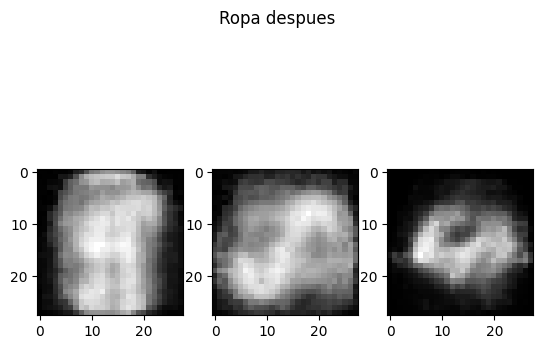

In [15]:
test_predictions = model.predict(corrupted_samples_test)

fig, axs = plt.subplots(1, 3,
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(corrupted_samples_test[i], cmap=plt.get_cmap('gray'))
plt.suptitle("Digitos antes")

fig, axs = plt.subplots(1, 3)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_predictions[i], cmap=plt.get_cmap('gray'))
plt.suptitle("Digitos despues")


fig, axs = plt.subplots(1, 3,
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten(), start=1):
    ax.imshow(corrupted_samples_test[-i], cmap=plt.get_cmap('gray'))
plt.suptitle("Ropa antes")

fig, axs = plt.subplots(1, 3)
for i, ax in enumerate(axs.flatten(), start=1):
    ax.imshow(test_predictions[-i], cmap=plt.get_cmap('gray'))
plt.suptitle("Ropa despues");

Finalmente, comparamos como es el histograma del error cometido para cada uo de los dos tipos de imágenes.

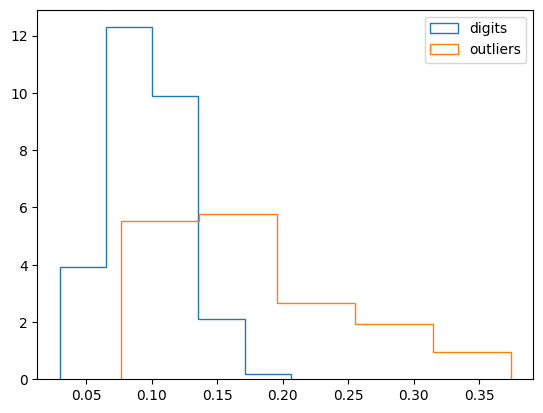

In [16]:
errors = np.mean(np.abs(corrupted_samples_test - test_predictions), (1, 2))
error_digits = errors[:-N_SAMPLES_OUTLIERS_TEST]
error_outliers = errors[-N_SAMPLES_OUTLIERS_TEST:]
plt.hist(error_digits, label="digits", density=True, histtype="step", bins=5)
plt.hist(error_outliers, label="outliers", density=True, histtype="step", bins=5)
plt.legend();

# Autoencoder con CNNs

## Entrenamiento del modelo

In [17]:
# Create and train autoencoder.
EPOCHS = 100

#ENCODER
inp = keras.layers.Input((28, 28, 1)) # * Should you not have to flatten this first? - This code also looks super inefficient
e = keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)
e = keras.layers.Dropout(DR_RATE)(e)
e = keras.layers.MaxPooling2D((2, 2))(e) # * Defining a max pooling for properties in a 2x2 not sure if the stride is defined
e = keras.layers.Conv2D(64, (3, 3), activation='relu')(e)
e = keras.layers.Dropout(DR_RATE)(e)
e = keras.layers.MaxPooling2D((2, 2))(e)
e = keras.layers.Conv2D(64, (3, 3), activation='relu')(e)
e = keras.layers.Dropout(DR_RATE)(e)
l = keras.layers.Flatten()(e) # Flatten the output - So we're reducing it from 28 x 28 to a 7x7
l = keras.layers.Dense(49, activation='tanh')(l)#, activity_regularizer=tf.keras.regularizers.l1())(l)

#DECODER
d = keras.layers.Reshape((7,7,1))(l)
d = keras.layers.Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d) # ! - You see here how we have the transpose?!
d = keras.layers.Dropout(DR_RATE)(d)
d = keras.layers.BatchNormalization()(d)
d = keras.layers.Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = keras.layers.Dropout(DR_RATE)(d)
d = keras.layers.BatchNormalization()(d)
d = keras.layers.Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
d = keras.layers.Dropout(DR_RATE)(d)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d) # * Output
model = keras.models.Model(inp, decoded) # * Define the input and the output

model.compile(loss='mse', optimizer = keras.optimizers.Adam(lr=5e-4),
              metrics =['mean_absolute_error', "mse"])
model.summary()
history = model.fit(corrupted_samples_train, corrupted_samples_train,
                    validation_split=0.2,
                    epochs=EPOCHS, batch_size=64, verbose=1,
                    shuffle=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 dropout_3 (Dropout)         (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 11, 11, 64)        0         
                                                             

In [49]:
 # ! - Alternativa Yago con modelo autoencoder usando el Subclassing API, en lugar de hacerlo linea a linea: 
class CustomAutoencoder(keras.Model): 
    def __init__(self, dropout_rate): 
        super(CustomAutoencoder, self).__init__()
        self.dropout_rate = dropout_rate

        # Encoder: 
        self.encoder = keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout_rate),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Flatten(),
            layers.Dense(49, activation='tanh')
        ])

        # Decoder: 
        self.decoder = keras.Sequential([
            layers.Reshape((7, 7, 1)),
            layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Dropout(self.dropout_rate),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Dropout(self.dropout_rate),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.Dropout(self.dropout_rate),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs): 
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded 

In [51]:
autoencoder = CustomAutoencoder(dropout_rate=DR_RATE)
autoencoder.compile(loss='mse', optimizer = tf.keras.optimizers.legacy.Adam(lr=5e-4),
              metrics =['mean_absolute_error', "mse"])

history = autoencoder.fit(corrupted_samples_train, corrupted_samples_train,
                    validation_split=0.2,
                    epochs=EPOCHS, batch_size=64, verbose=1,
                    shuffle=True)

autoencoder.summary()

Epoch 1/100
14/14 [==============================] - 2s 92ms/step - loss: 0.2107 - mean_absolute_error: 0.4181 - mse: 0.2107 - val_loss: 0.2200 - val_mean_absolute_error: 0.4608 - val_mse: 0.2200
Epoch 2/100
14/14 [==============================] - 1s 80ms/step - loss: 0.1017 - mean_absolute_error: 0.2221 - mse: 0.1017 - val_loss: 0.2102 - val_mean_absolute_error: 0.4505 - val_mse: 0.2102
Epoch 3/100
14/14 [==============================] - 1s 88ms/step - loss: 0.0913 - mean_absolute_error: 0.1766 - mse: 0.0913 - val_loss: 0.2037 - val_mean_absolute_error: 0.4433 - val_mse: 0.2037
Epoch 4/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0823 - mean_absolute_error: 0.1769 - mse: 0.0823 - val_loss: 0.1991 - val_mean_absolute_error: 0.4383 - val_mse: 0.1991
Epoch 5/100
14/14 [==============================] - 1s 89ms/step - loss: 0.0740 - mean_absolute_error: 0.1671 - mse: 0.0740 - val_loss: 0.1945 - val_mean_absolute_error: 0.4330 - val_mse: 0.1945
Epoch 6/100
14/14 [=

In [18]:
encoder = tf.keras.models.Model(inp, l, name="encoder")
decoder = tf.keras.models.Model(l, decoded, name="decoder")

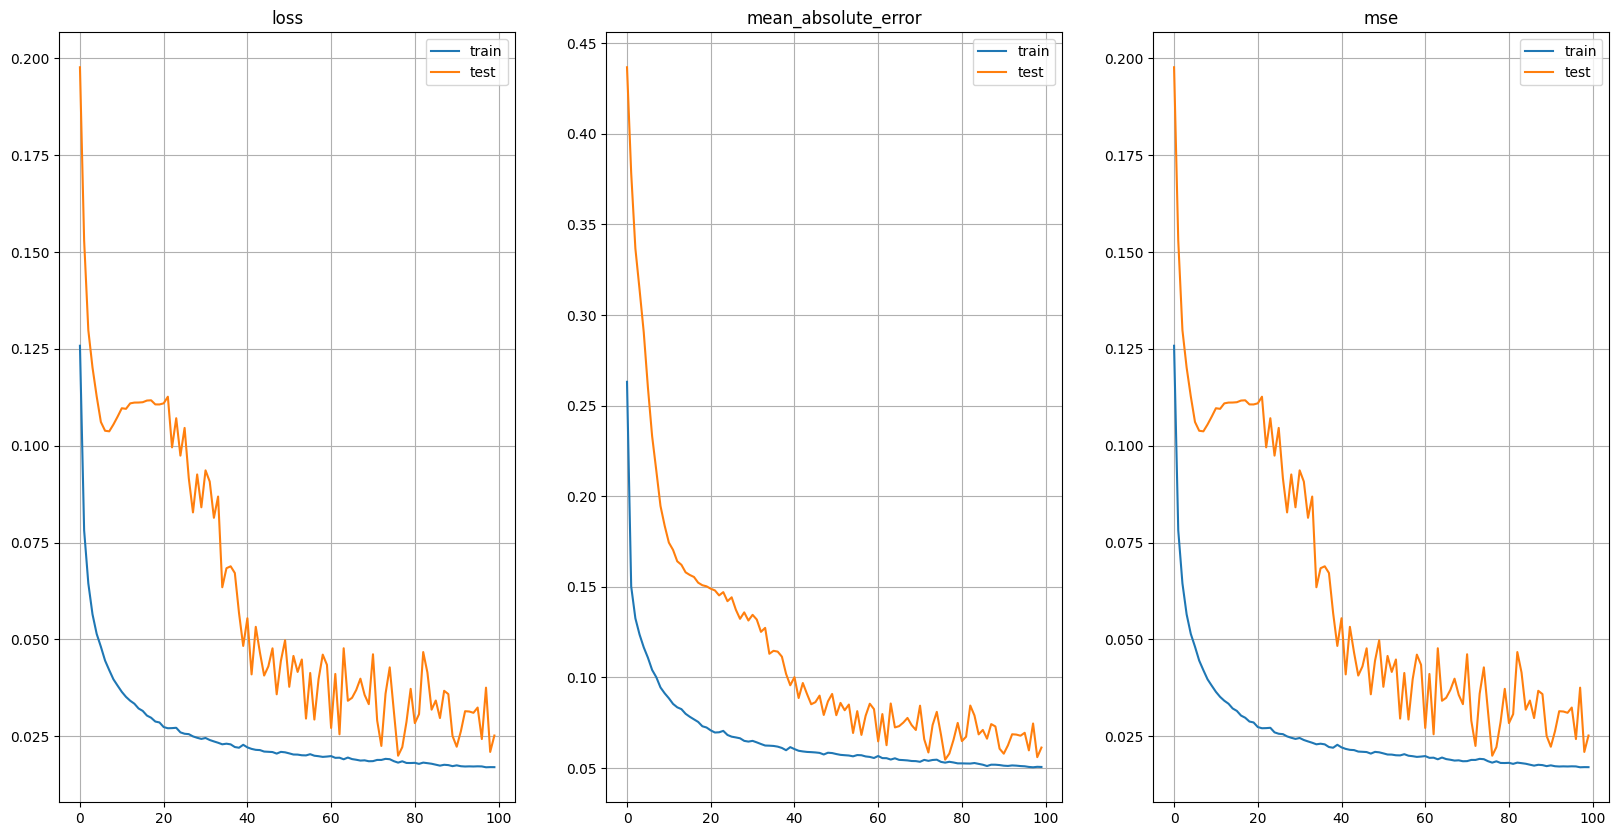

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
metrics_names = [m for m in history.history.keys() if "val_" not in m]
for i, (m, ax) in enumerate(zip(metrics_names, axs.flatten())):
    axs[i].plot(history.history[m], label="train")
    axs[i].plot(history.history["val_" + m], label="test")
    axs[i].set_title(m)
    axs[i].grid(True)
    axs[i].legend()

## Visualización de ejemplos

In [20]:
train_predictions = model.predict(corrupted_samples_train).squeeze()


33/33 [==============================] - 1s 16ms/step


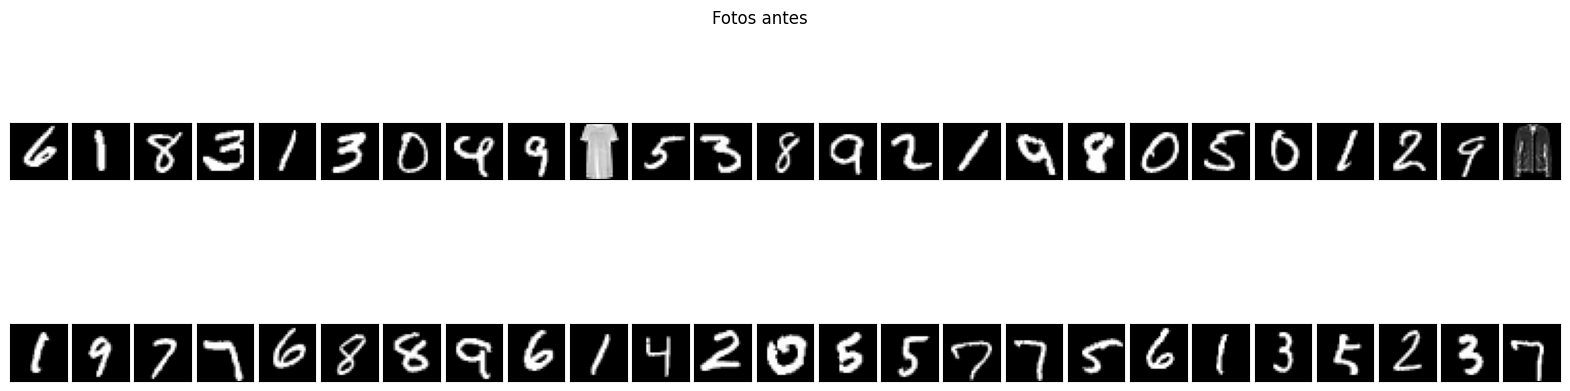

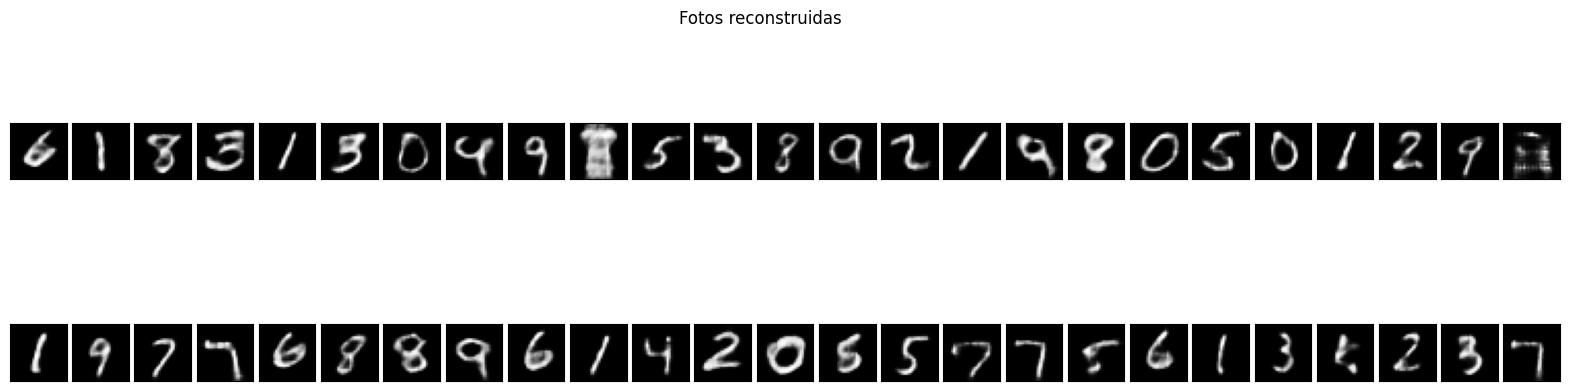

In [21]:


N = 50
fig, axs = plt.subplots(2, N // 2, figsize=(20, 5),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for sample, ax in zip(corrupted_samples_train, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Fotos antes")

fig, axs = plt.subplots(2, N // 2, figsize=(20, 5),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for sample, ax in zip(train_predictions, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Fotos reconstruidas");

## Outliers generados

In [22]:
errors = np.mean(np.abs(corrupted_samples_train - train_predictions), (1, 2))
indices_ordered_by_error = sorted(enumerate(errors), key=lambda x: x[1], reverse=True)

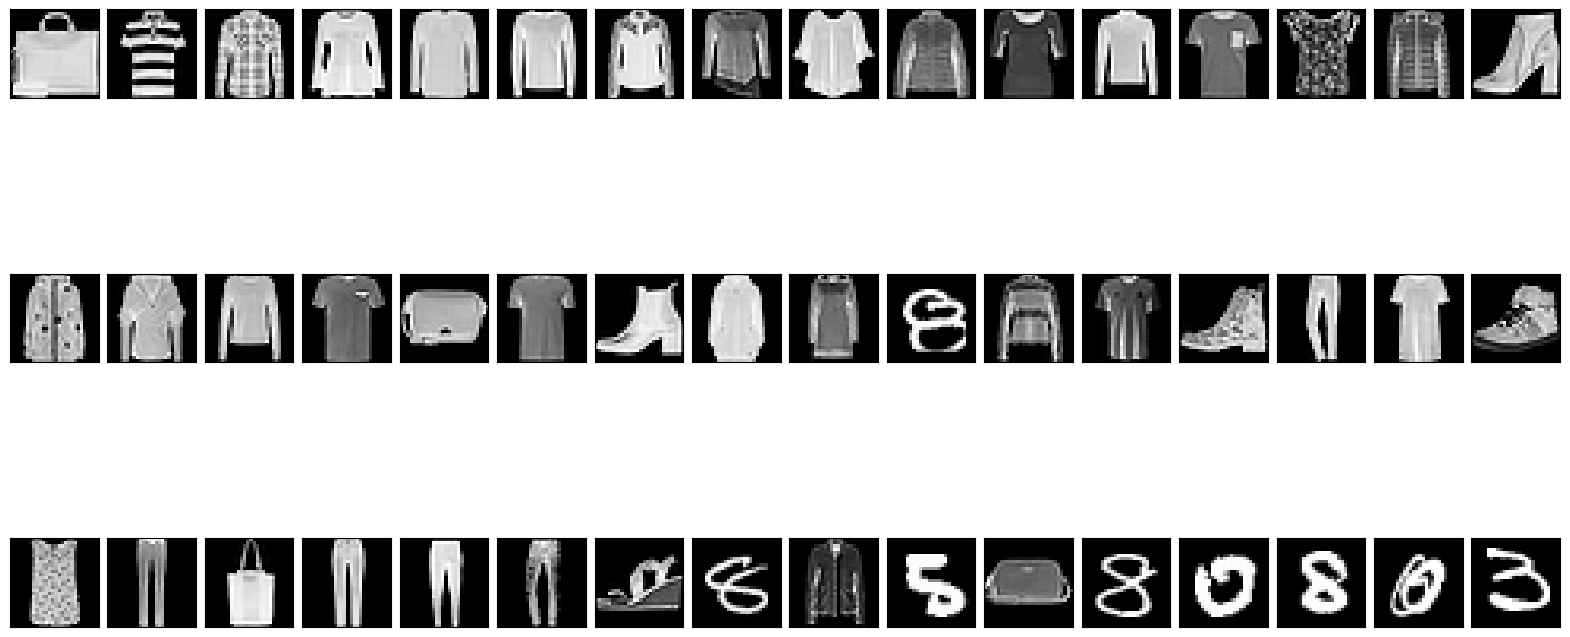

In [23]:
n_outliers = N_SAMPLES_OUTLIERS_TRAIN

fig, axs = plt.subplots(3, n_outliers // 3, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for (i, e), ax in zip(indices_ordered_by_error[:n_outliers], axs.flatten()):
    ax.imshow(corrupted_samples_train[i], cmap=plt.get_cmap('gray'))

315/315 [==============================] - 5s 16ms/step


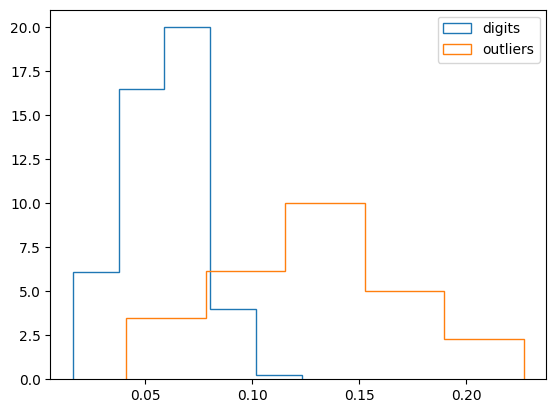

In [24]:
test_predictions = model.predict(corrupted_samples_test).squeeze()

errors = np.mean(np.abs(corrupted_samples_test - test_predictions), (1, 2))
error_digits = errors[:-N_SAMPLES_OUTLIERS_TEST]
error_outliers = errors[-N_SAMPLES_OUTLIERS_TEST:]
plt.hist(error_digits, label="digits", density=True, histtype="step", bins=5)
plt.hist(error_outliers, label="outliers", density=True, histtype="step", bins=5)
plt.legend();

315/315 [==============================] - 6s 17ms/step


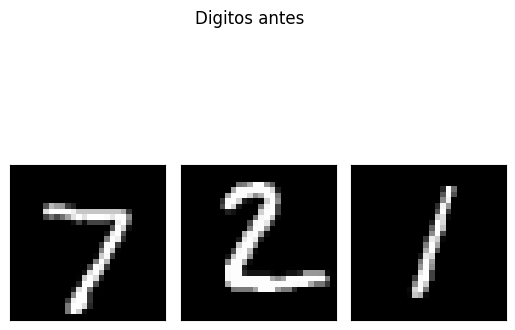

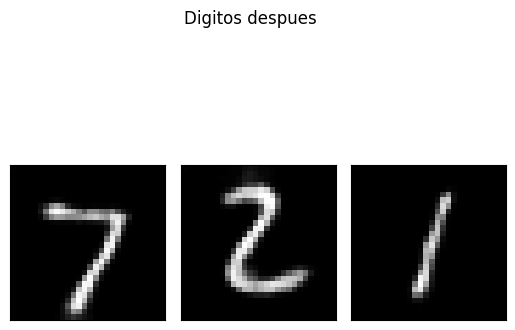

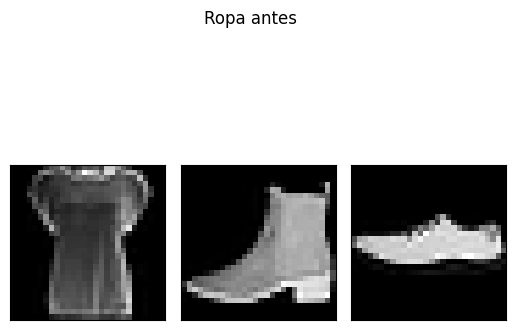

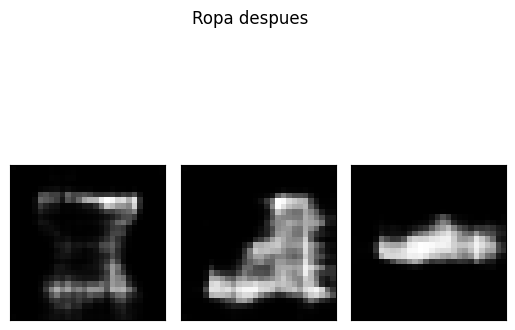

In [25]:
test_predictions = np.squeeze(model.predict(corrupted_samples_test))

fig, axs = plt.subplots(1, 3, subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(corrupted_samples_test[i], cmap=plt.get_cmap('gray'))
plt.suptitle("Digitos antes")

fig, axs = plt.subplots(1, 3, subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_predictions[i], cmap=plt.get_cmap('gray'))
plt.suptitle("Digitos despues")


fig, axs = plt.subplots(1, 3, subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten(), start=1):
    ax.imshow(corrupted_samples_test[-i], cmap=plt.get_cmap('gray'))
plt.suptitle("Ropa antes")

fig, axs = plt.subplots(1, 3, subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axs.flatten(), start=1):
    ax.imshow(test_predictions[-i], cmap=plt.get_cmap('gray'))
plt.suptitle("Ropa despues");

# Caso de uso: Clustering

Usando el encoder, transformamos todas las images en un espacio de dimensionadlidad mucho menor.

In [26]:
embeddings_test = encoder.predict(test_images)

313/313 [==============================] - 1s 3ms/step


Utilizando TSNE, reducimos a solo 2 dimensiones.

In [27]:
embeddings_2D = TSNE(2).fit_transform(embeddings_test)

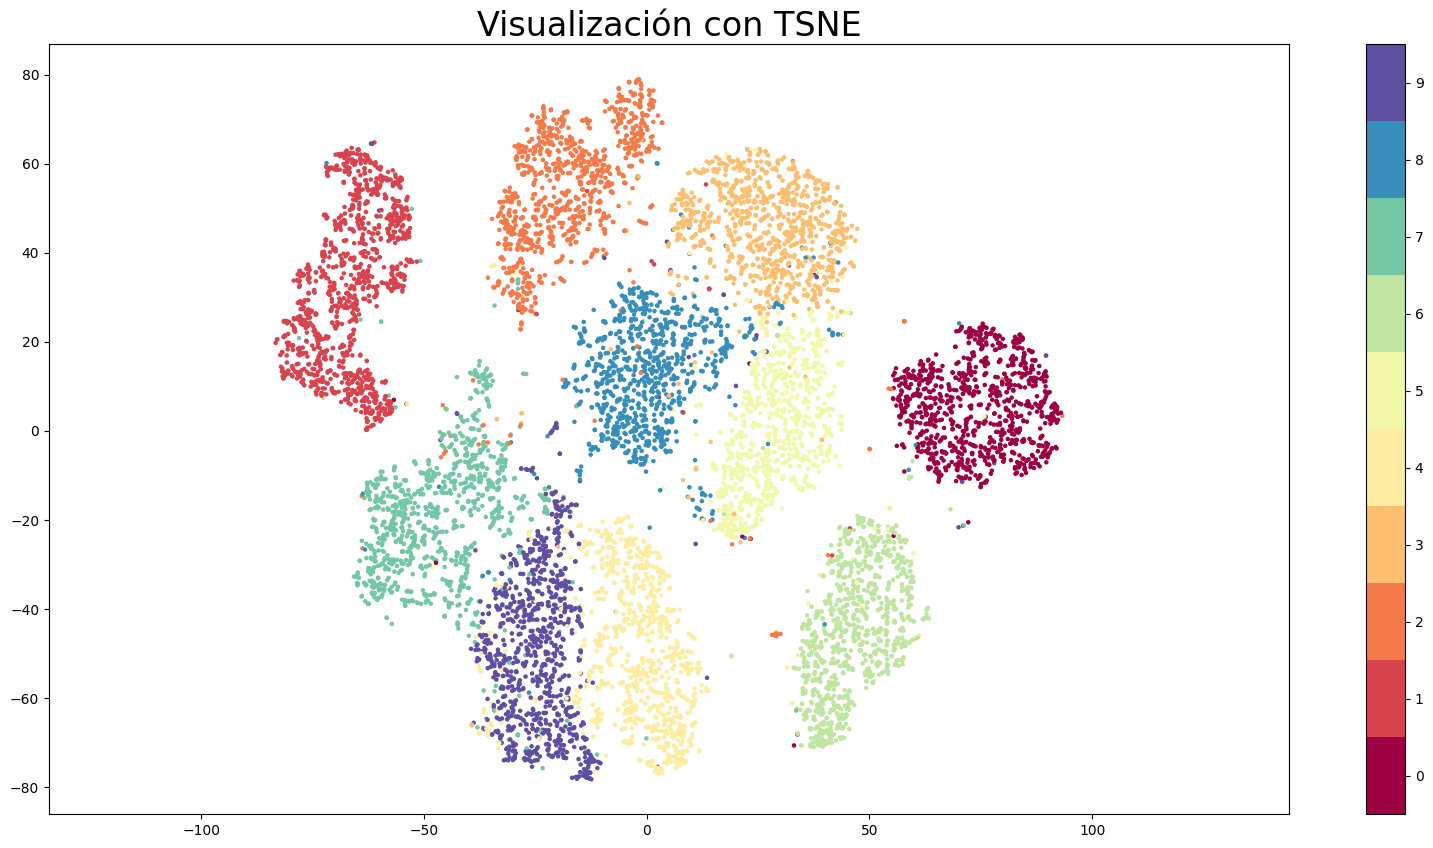

In [28]:
plt.figure(figsize=(20, 10))


plt.scatter(embeddings_2D[:, 0], embeddings_2D[:, 1], s=5, c=test_labels, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualización con TSNE', fontsize=24);

# Caso de uso: Denoising

Probamos a añadir un poco de ruido a imagenes del dataset de test y lo pasamos a través del autoencoder.

1/1 [==============================] - 0s 12ms/step


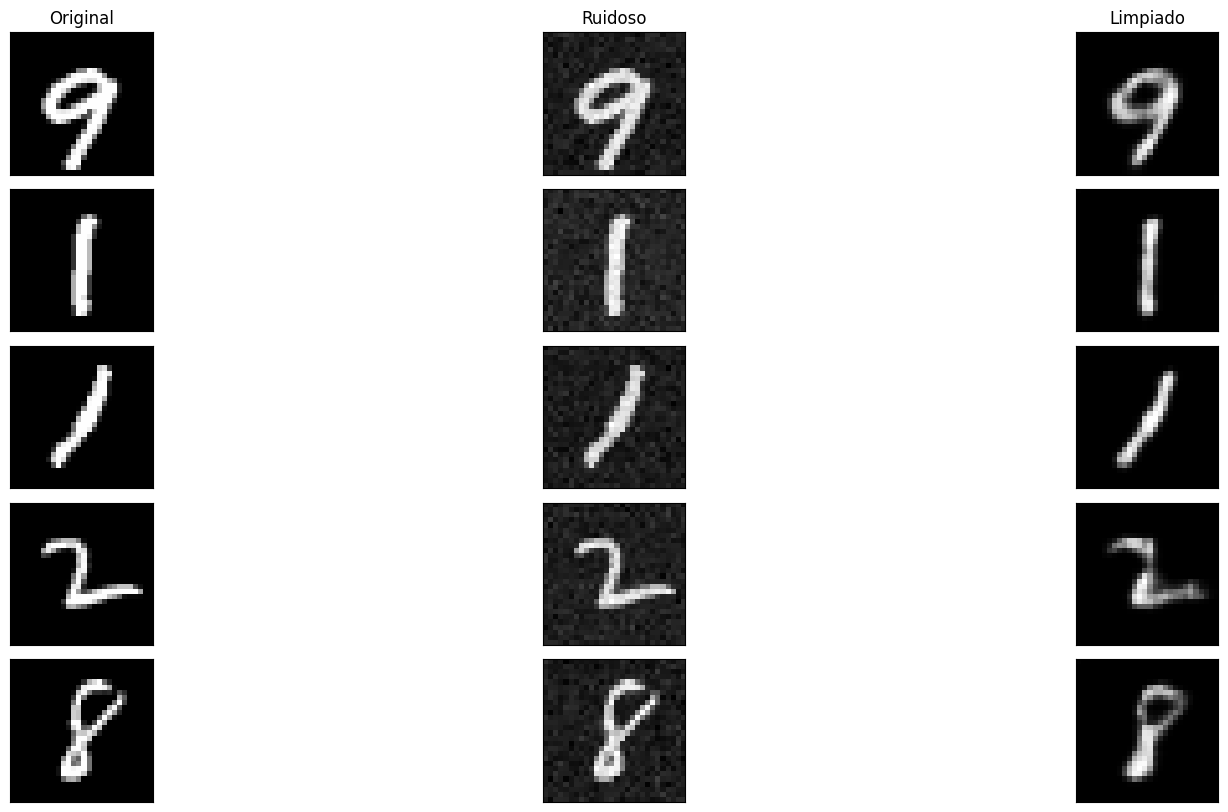

In [29]:
number_samples = 5
noise_power = 0.05


fig, axs = plt.subplots(number_samples, 3, figsize=(20, 10), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, image_chosen in enumerate(random.sample(range(len(test_images)), number_samples)):
    sample_image = test_images[[image_chosen], :, :]
    sample_image_noised = sample_image + noise_power * np.random.randn(*sample_image.shape)
    sample_image_denoised = model.predict(sample_image_noised)
    axs[i][0].imshow(sample_image.squeeze(), cmap='gray')
    axs[i][1].imshow(sample_image_noised.squeeze(), cmap='gray')
    axs[i][2].imshow(sample_image_denoised.squeeze(), cmap='gray')
axs[0][0].set_title("Original")
axs[0][1].set_title("Ruidoso")
axs[0][2].set_title("Limpiado");

# Caso de uso: Missing values reconstruction

Eliminamos aleatoriamente unos pocos píxeles de la imagen y lo pasamos a través del autoencoder.

1/1 [==============================] - 0s 11ms/step


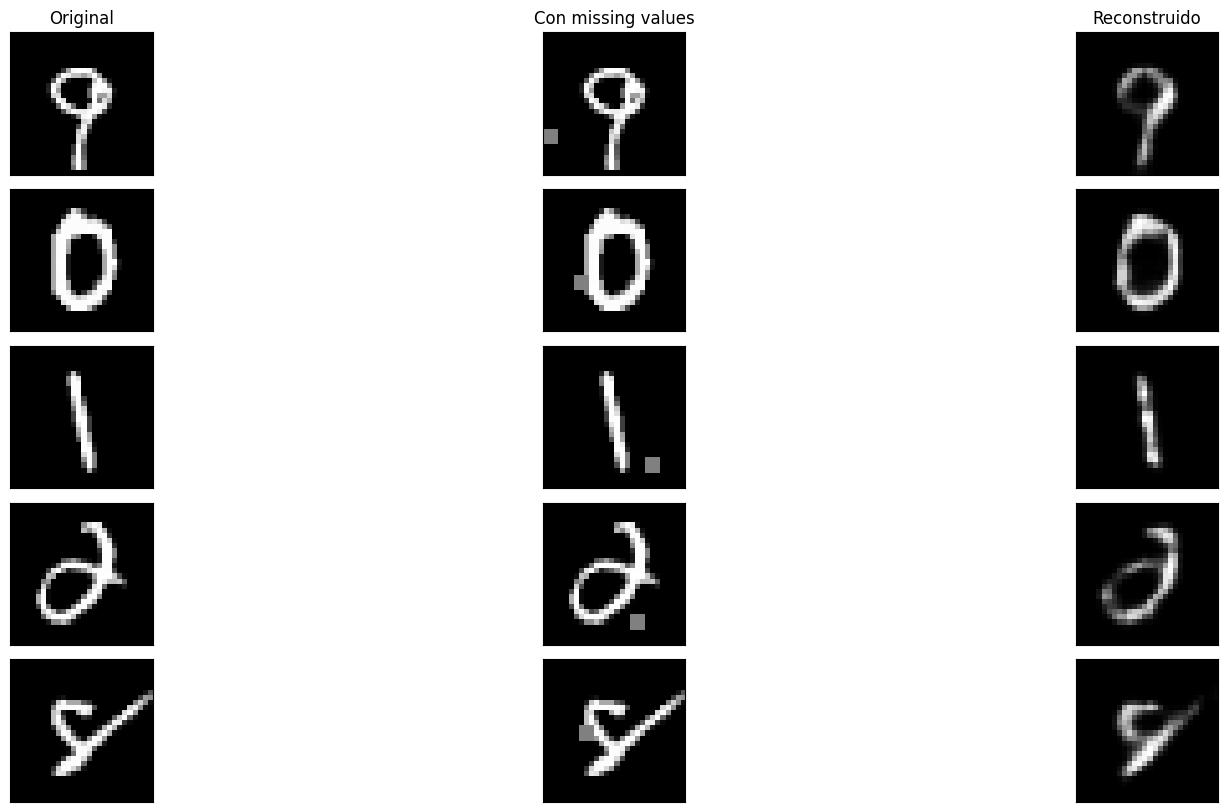

In [30]:
number_samples = 5

window_corrupted = 3

fig, axs = plt.subplots(number_samples, 3, figsize=(20, 10), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, image_chosen in enumerate(random.sample(range(len(test_images)), number_samples)):
    sample_image = test_images[[image_chosen], :, :]
    sample_image_corrupted = sample_image.copy()

    x = random.randint(0, sample_image_corrupted.shape[1])
    y = random.randint(0, sample_image_corrupted.shape[2])

    sample_image_corrupted[0, x:x + window_corrupted, y: y + window_corrupted] = 0.5

    sample_image_rebuilt = model.predict(sample_image_corrupted)

    axs[i][0].imshow(sample_image.squeeze(), cmap='gray')
    axs[i][1].imshow(sample_image_corrupted.squeeze(), cmap='gray')
    axs[i][2].imshow(sample_image_rebuilt.squeeze(), cmap='gray')

axs[0][0].set_title("Original")
axs[0][1].set_title("Con missing values")
axs[0][2].set_title("Reconstruido");

# Caso de uso: clasificación supervisada con pocas muestras

Probemos ahora la construcción de un modelo de clasificación usando aprendizaje semisupervisado.

Vamos a tomar unas pocas muestras que consideraremos nuestras muestras etiquetadas.

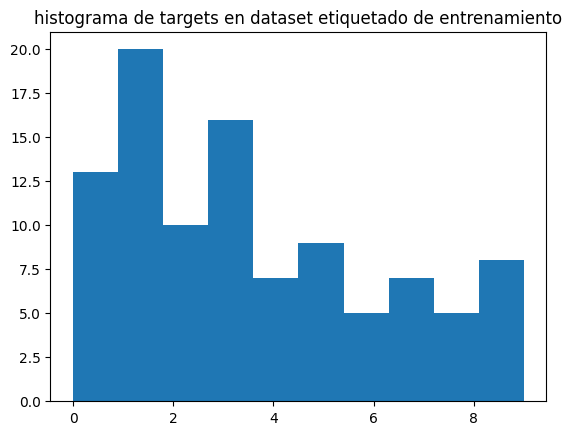

In [31]:
n_samples = 100 # Number of supervised samples

indices_samples = random.sample(range(len(test_images)), n_samples)
images_to_train = test_images[indices_samples]
labels_to_train = test_labels[indices_samples]
plt.hist(labels_to_train)
plt.title("histograma de targets en dataset etiquetado de entrenamiento");

Creamos nuestro modelo de clasificación usando una copia de nuestro encoder.

In [32]:
encoder_to_train = keras.models.clone_model(encoder) # Gets a copy of the encoder
encoder_to_train.set_weights(encoder.get_weights()) # Sets the same weights that the original encoder

encoder_to_train.trainable = False # Sets the weights of the encoder to non trainable
trainable_layers = [l for l in encoder_to_train.layers if l.weights]
for i in [-1, -2]: # Sets the last two layers of the encoder to trainable
    trainable_layers[i].trainable = True

In [33]:
inp = keras.layers.Input((28, 28, 1))
encoded_inputs = encoder_to_train(inp)
x = encoded_inputs
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(50, activation="relu")(encoded_inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(45, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(30, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(10, activation="softmax")(x)
clasification_model = keras.models.Model(inp, x)

In [34]:
clasification_model.compile(keras.optimizers.Adam(), "sparse_categorical_crossentropy", metrics=["accuracy"])

Entrenamos el modelo.

In [35]:
class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes=list(range(10)), y=labels_to_train)
class_weights = {i: class_weights[i] for i in range(10)}

history = clasification_model.fit(images_to_train, labels_to_train, validation_data=(test_images[-300 : ], test_labels[-300 : ]), epochs=150, verbose=0, batch_size=32,
                                 class_weight=class_weights)

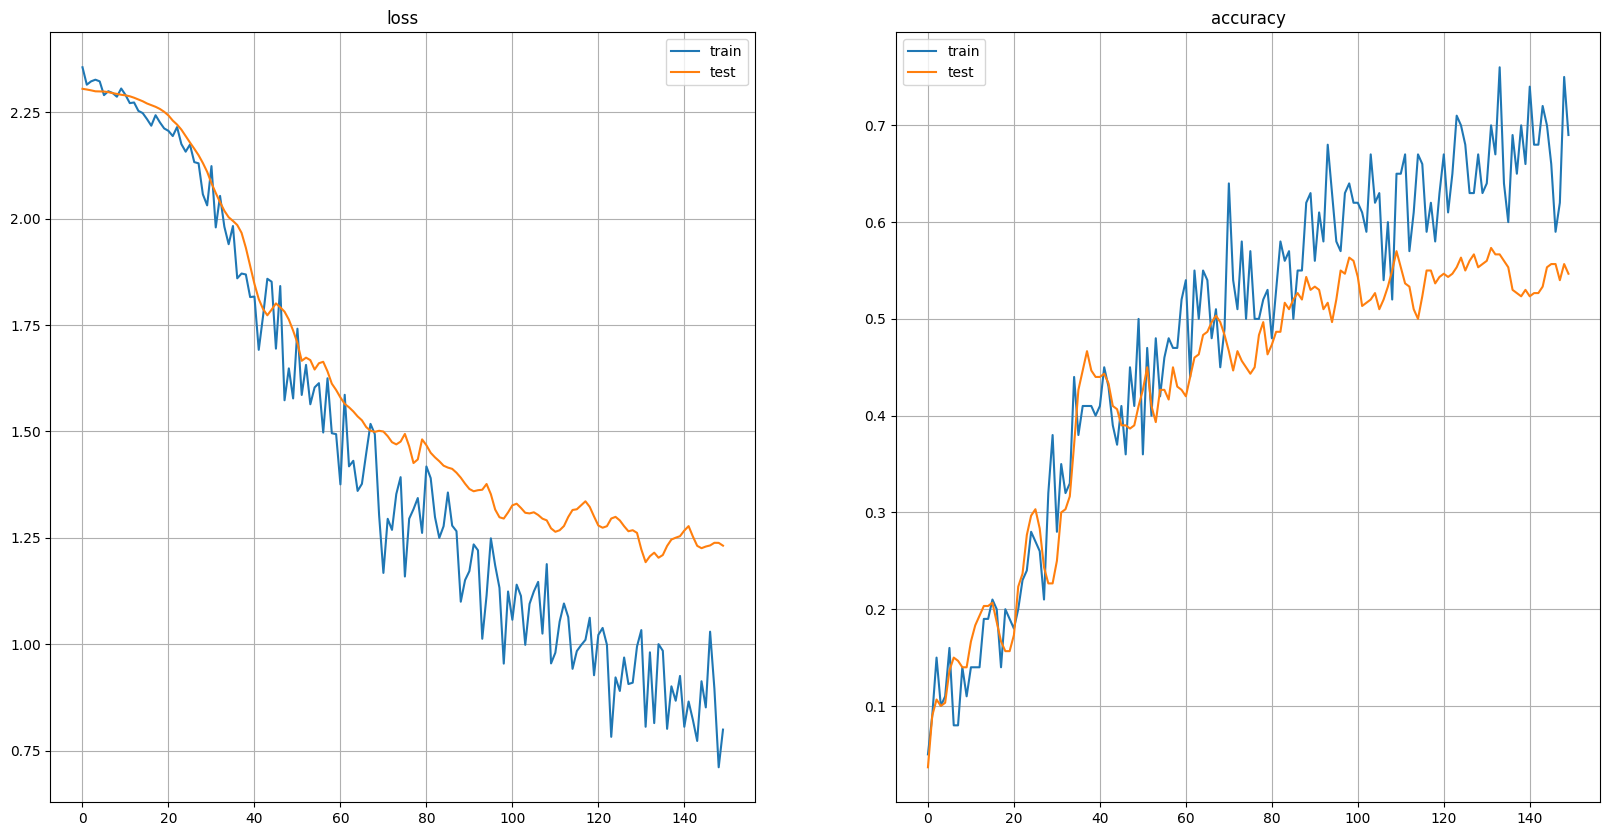

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
metrics_names = [m for m in history.history.keys() if "val_" not in m]
for i, (m, ax) in enumerate(zip(metrics_names, axs.flatten())):
    axs[i].plot(history.history[m], label="train")
    axs[i].plot(history.history["val_" + m], label="test")
    axs[i].set_title(m)
    axs[i].grid(True)
    axs[i].legend()

Mostramos unos pocos ejemplos para ver como han sido clasificados por el modelo.

1/1 [==============================] - 0s 76ms/step


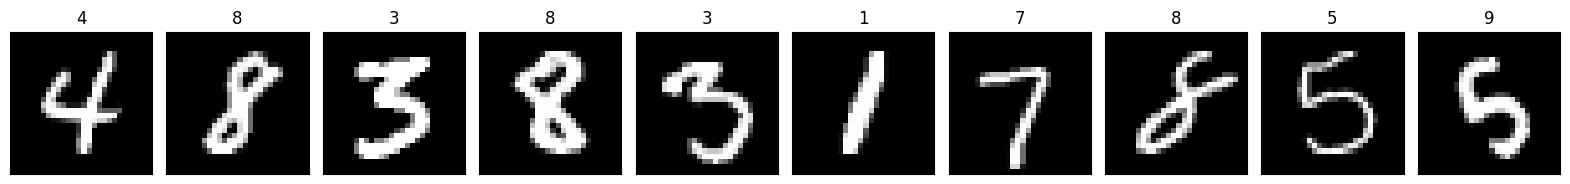

In [37]:
N = 10
fig, axs = plt.subplots(1, N, figsize=(20, 10), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
samples_test = test_images[random.sample(range(len(test_images)), N)]
predictions = clasification_model.predict(samples_test)
predictions = np.argmax(predictions, axis=-1)

for i in range(N):

    axs[i].imshow(samples_test[i].squeeze(), cmap='gray')
    axs[i].set_title(predictions[i])

# Caso de uso: Modelo generativo

Vamos a generar nuevas muestras no vistas, por existentes en nuestro dataset. Se parte de aquellas muestras con menor error de reconstrucción.

In [38]:
reconstruction = decoder.predict(embeddings_test)
errors = np.linalg.norm(test_images.reshape(-1, 28 * 28) - reconstruction.reshape(-1, 28 * 28), axis=0)

313/313 [==============================] - 5s 15ms/step


In [39]:
indices_sorted, errors_sorted = zip(*sorted(list(enumerate(errors)), key=lambda x: x[1]))

Mostramos las muestras que mejor se han reconstruido:

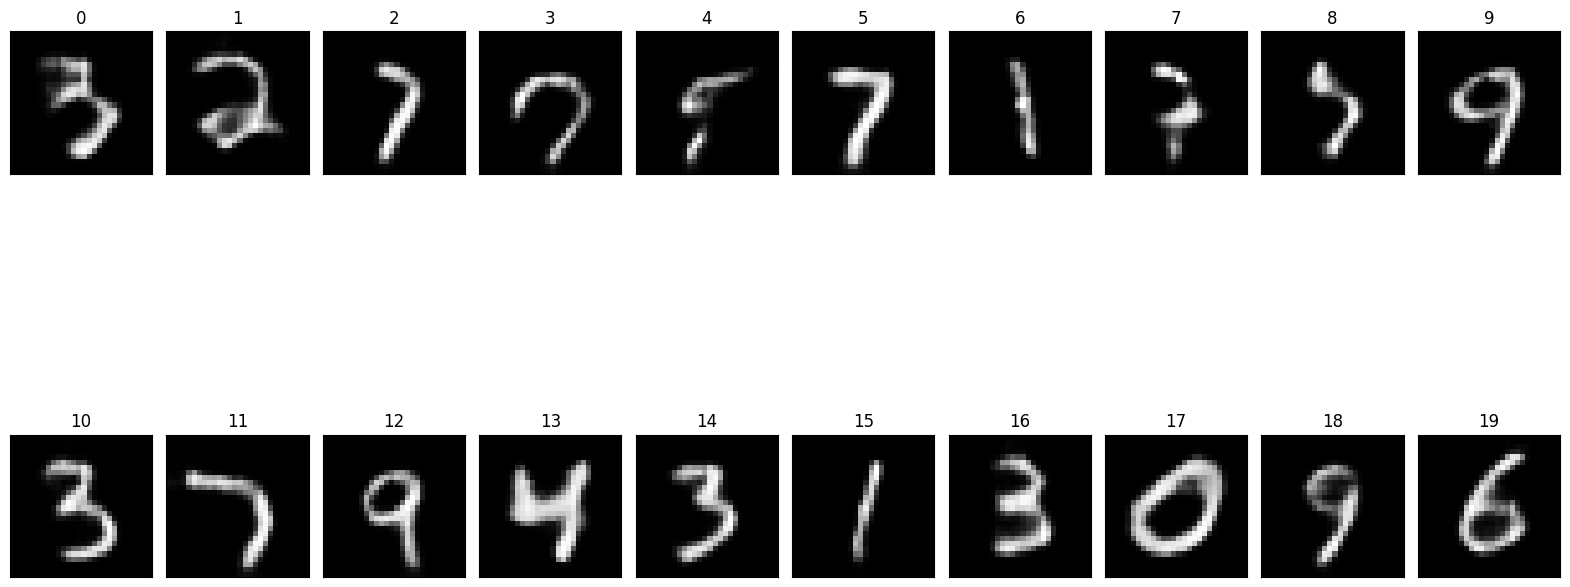

In [40]:

fig, axs = plt.subplots(2, 10, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for (i, ind), ax in zip(enumerate(indices_sorted[:20]), axs.flatten()):
    ax.imshow(reconstruction[ind], cmap=plt.get_cmap('gray'))
    ax.set_title(i)

Elegimos dos de ellas. Poner a continuación dos índices de los de la imagen.

In [41]:
number_a = 7
number_b = 2

embedding_a = embeddings_test[indices_sorted[number_a], :]
mean_a = embeddings_test[indices_sorted[number_a], :]

embedding_b = embeddings_test[indices_sorted[number_b], :]
mean_b = embeddings_test[indices_sorted[number_b], :]

Buscamos los encodings intermedios entre los dos vectores que hemos obtenido y los pasamos por el decoder.

1/1 [==============================] - 0s 22ms/step


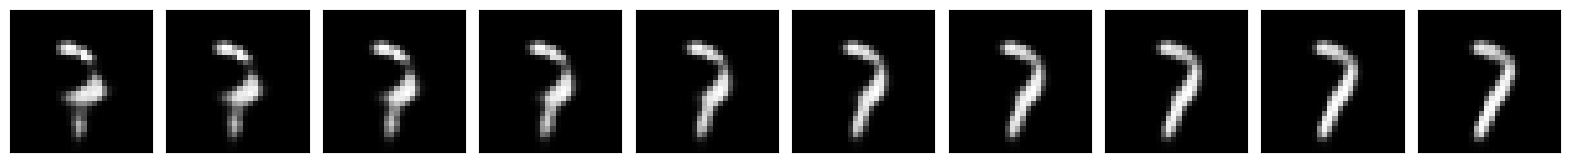

In [42]:
number_samples = 10

fig, axs = plt.subplots(1, number_samples, figsize=(20, 10), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

v = mean_b - mean_a

for alpha, ax in zip(np.linspace(0, 1, number_samples), axs.flatten()):
    x = mean_a + alpha * v
    ax.imshow(decoder.predict(np.expand_dims(x, 0)).squeeze(), cmap='gray')